### Le but de ce notebook est d'explorer la "Feature Visualization" qui consiste à visualiser et interpréter les caractéristiques apprises par un grand modèle de vision, dans le but de tirer de l'explicabilité dudit modèle.

#### Ici nous utiliserons vgg16 (archi facile à utilisée type features_extractor + classifier)

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch import nn
from torchvision import models, transforms

HookRegistration, est utilisée pour enregistrer des hooks. Avec PyTorch, les hooks sont des fonctions que l'on peut attacher à certains points de l'exécution d'un module de réseau neuronal (comme les couches) lors de la passe avant ou arrière. 
Ils peuvent être utilisés à diverses fins telles que le l'enregistrement des activations, la modification des gradients, ou dans ce cas, la capture des caractéristiques.

In [151]:
class HookRegistration():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

FeatureVisualization est la classe qui nous permet, étant donné un layer ou bien une potition dans la partie convolutive du réseau, de récupérer une visualization du résultats du passage d'une image d'entrée dans le réseau.


In [161]:
class FeatureVisualization:
    def __init__(self) -> None:
        self.net = models.vgg16(pretrained=True).cuda().eval()

        means = (0.485, 0.456, 0.406)
        stds = (0.229, 0.224, 0.225)
        mean_inverse = [-mean/std for mean, std in zip(means, stds)]
        std_inverse = [1/std for std in stds]

        self.inverse_transform = transforms.Normalize(
            mean=mean_inverse,
            std=std_inverse
        )
        
    def __call__(self, layer):
        self.layer = layer

        plt.figure(figsize=(20,25))
        for i, filter_ in enumerate(range(0, 5)):
            plt.subplot(5, 5, i+1)
            img = self._get_random_img()
            self._visualize(img, filter_)

    def _get_random_img(self, img_shape=224):
        return torch.rand((1, 3, img_shape, img_shape), requires_grad=True, device="cuda")

    def _visualize(self, img, channel):
        optimizer = optim.Adam([img], lr=0.1, weight_decay=1e-6)
        features_hook =  HookRegistration(self.net.features[self.layer])

        for _ in range(20): 
            optimizer.zero_grad()
            self.net(img)
            features_map = features_hook.features
            loss = -features_map[0, channel].mean() 
            loss.backward()
            optimizer.step()
        
        features_hook.close()
        self._display(img)
    
    def _display(self, img):
        img = self.inverse_transform(img.squeeze(0)).cpu().detach().numpy()
        img = np.transpose(img, (1,2,0))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.tight_layout()

In [162]:
visualize_feature = FeatureVisualization()
visualize_feature.net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### On visualise pour différent *layer*, un nombre de 5 filtre à cette position dans le réseau. Ceci nous permet de voir quelques patterns appris par le réseau.

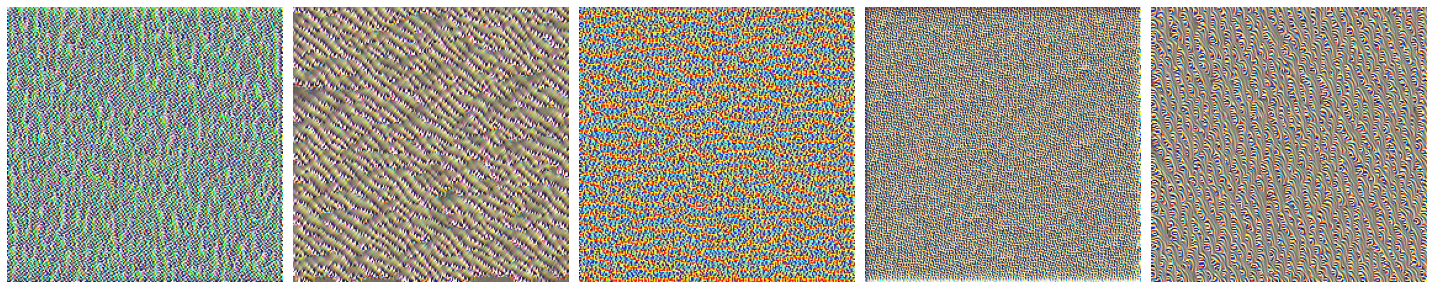

In [163]:
visualize_feature(layer=5) # conv2d at 5th layer

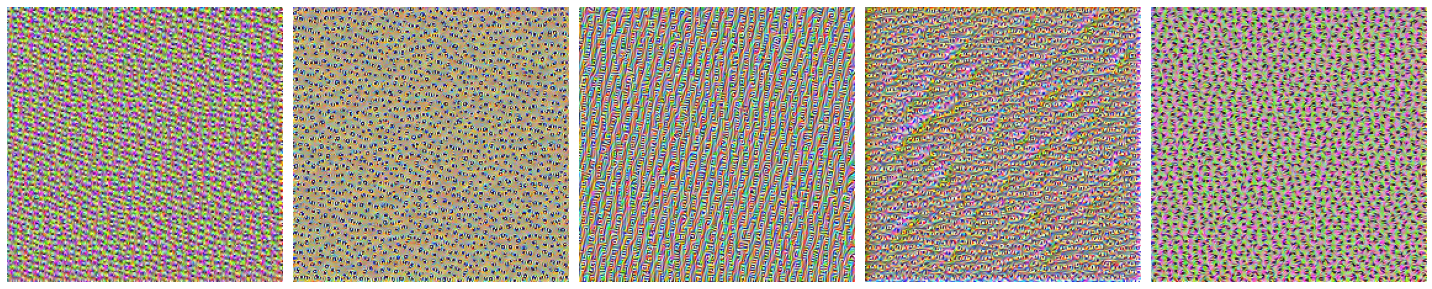

In [164]:
visualize_feature(layer=10) # conv2d at 10th layer

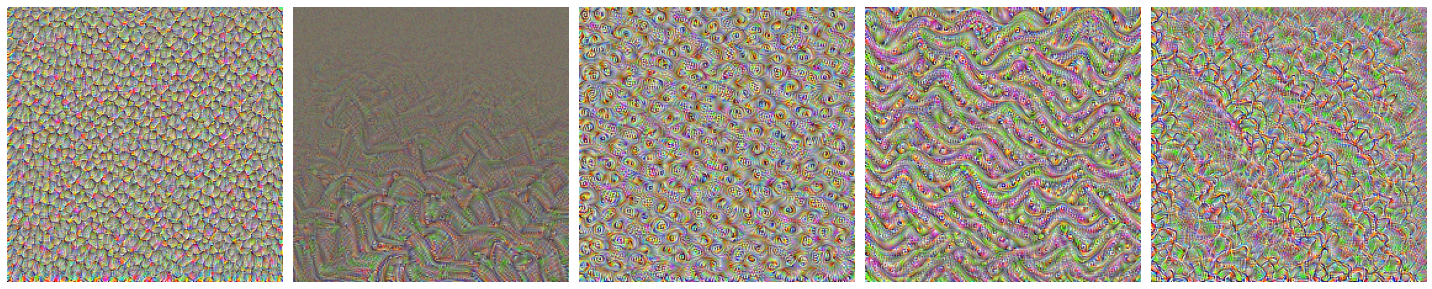

In [165]:
visualize_feature(layer=19)# conv2d at 19th layer